# mass binning

In [2]:
from   astropy.io import fits
import numpy as np
from   astropy.table import Table
import matplotlib.pyplot as plt
from   scripts.tools    import *
from   scripts.hst3d      import *
from   scripts.jwst       import *
obj_lis = Table.read('obj_lis_selected.fits')

bins_m = [-np.inf,9.75,10.5,np.inf]
binning_m = np.digitize(np.log10(obj_lis['mass']),bins_m)
bins_z  = [-np.inf,1.11,np.inf]
binning_z = np.digitize(obj_lis['z_MAP'],bins_z)
bin_label_m = ['8<logm<9.75','9.75<logm<10.5','10.5<logm<11.25']
bin_label_z = ['0.7<z<1.1','1.1<z<1.5']

obj_lis['bin_m'] = binning_m
obj_lis['bin_z'] = binning_z
obj_lis.write('obj_lis_selected_bins.fits',overwrite=True)
select = np.logical_and(np.logical_and(obj_lis['tag']!='agn',obj_lis['manual_select']=='keep'),obj_lis['mass']>0)
select = np.logical_and(obj_lis['manual_select']=='keep',obj_lis['mass']>0)

def bin_center(r_lis):
    diff = np.diff(r_lis)  # Calculate differences between consecutive elements
    diff = diff[diff > 0]  # Keep only positive differences
    return r_lis + np.mean(diff) / 2  # Return r_lis plus half the mean of the differences

print(len(obj_lis))
obj_lis_sel = obj_lis[select]
binning_m_sel = binning_m[select]
binning_z_sel = binning_z[select]
print(len(obj_lis_sel))


C:\Users\26715\AppData\Local\Temp\ipykernel_40020\3389231789.py:11: RuntimeWarning: invalid value encountered in log10
  binning_m = np.digitize(np.log10(obj_lis['mass']),bins_m)


158
83


plot surface profile in mass binning

In [15]:
import os
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm
from matplotlib import colors
from matplotlib.pyplot import cm
from matplotlib import use
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)
from scripts.tools import *


def plot_balmer_decrem(obj, plot, plot_var, crop_size=50):
    #try:
        # Construct the path to the FITS file
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"
        
        # Open the FITS file
        with fits.open(path) as hdu:
            # Determine the center of the image
            shape = hdu[3].data.shape[0]
            si = (shape - crop_size) // 2; 
            ei = si + crop_size

            #extract segmentation map
            if find_data('SEG_MOD',hdu) != None:
                seg = find_data('SEG_MOD',hdu)[1].data
            else:
                seg = find_data('SEG',hdu)[1].data

            #effective radius (in arcsec)
            r_eff = obj['re']
             
            # Create a figure with subplots
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            axes = axes.flatten()

            # Loop through the specified image names and plot them
            #here i try to add segmentation map effect to the image
            for i, name in enumerate(['DSCI', 'LINE_HA', 'LINE_HB_CONV', '2D_BALMER']):
                image = find_data(name, hdu)[1]
                titles = {
                        "DSCI": 'direct imaging',
                        "LINE_HA": r"H$\alpha$",
                        "LINE_HB_CONV": r"H$\beta$",
                        "2D_BALMER": r'$H\alpha / H\beta$'
                        }
                data = image.data[si:ei, si:ei]
                # Extract the segmentation map for the same region
                seg_crop = seg[si:ei, si:ei]
                # Create a mask where the segmentation map matches the object ID
                mask = seg_crop == obj['ID']
                
                ax = axes[i]
                ax.tick_params(direction='in',which='both', top=True, right=True)

                # Plot the original data with plasma_r colormap
                norm = colors.LogNorm()#vmin=np.nanmin(data),vmax = np.nanmax(data))
                if name == '2D_BALMER':
                    norm = colors.Normalize(vmin=0, vmax=10)
                im = ax.imshow(np.where(mask,data,np.nan), norm=norm, origin='lower', cmap='plasma_r')
                
                # Convert the colormap to grayscale
                cmap = cm.get_cmap('plasma_r')
                cmap_colors = cmap(np.arange(cmap.N))
                hsv_colors = rgb_to_hsv(cmap_colors[:, :3])
                hsv_colors[:, 1] = 0  # Set saturation to 0 to convert to grayscale
                gray_cmap = colors.ListedColormap(hsv_to_rgb(hsv_colors))

                # Overlay the segmentation map with gray colormap and lower transparency
                ax.imshow(np.where(np.logical_not(mask),data,np.nan), norm=norm, origin='lower', cmap=gray_cmap, alpha=0.5)
                
                # Plot a circle representing the effective radius
                circ = plt.Circle((crop_size/2-1, crop_size/2-1), r_eff / 0.1, color='blue', fill=False, linestyle='--',label='effective radius',linewidth=2)
                ax.add_patch(circ)

                ax.plot([3, 7], [4, 4])
                ax.text(5, 5, f"{round(obj['pixel_length'] * 4, 2)} kpc")
                ax.set_ylabel(f'{titles[name]}')
                ax.set_xticklabels([]);ax.set_yticklabels([])
                ax.legend()

            # Extract and plot the radial profiles
            r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_BV, A_Ha = np.vstack(find_data(plot, hdu)[1].data).transpose()
            r_var, ha_r_var, ha_r_err_var, hb_r_var, hb_r_err_var, balmer_r_var, balmer_r_err_var, E_BV_var, A_Ha_var = np.vstack(find_data(plot_var, hdu)[1].data).transpose()

            if True:
                # Plot the Ha radial profiles
                ax = plt.subplot2grid((2, 4), (1, 0))
                ax.errorbar(r, ha_r, yerr=ha_r_err, fmt='ro:', label=r'H$\alpha$, circular', alpha=0.5)
                ax.errorbar(r_var, ha_r_var, yerr=ha_r_err_var, fmt='go:', label=r'H$\alpha$, elliptical', alpha=0.5)

                #effective radius
                ax.axvspan(0, r_eff * obj['pixel_length'] / 0.1, color='grey', alpha=0.3)
                
                # Determine the plot limits
                arr = np.append(ha_r, ha_r_var)
                arr = arr[arr > 0]
                plot_min = np.nanmin(arr) * 0.05
                plot_max = np.nanmax(arr) * 100

                # Annotate the effective radius
                ax.annotate(
                    "",  # Only draw the arrow, no text
                    xy=(0, plot_min * 2),  # Right endpoint
                    xytext=(r_eff * obj['pixel_length'] / 0.1, plot_min * 2),  # Left endpoint
                    arrowprops=dict(arrowstyle="<->", lw=1.5, color="black"),  # Horizontal double arrow
                )
                ax.text(r_eff * obj['pixel_length'] / 0.1 / 2, plot_min * 2.1, 
                        r"$r_{eff}$", fontsize=12, color="black", ha="center",va='bottom')
                ax.set_xlabel('r [kpc]')
                ax.set_ylabel('flux [$10^{-17}$ erg/s/cm$^2$$]')
                ax.set_ylim(plot_min, plot_max)
                ax.set_xlim(0,3*obj['re']/0.1*obj['pixel_length'])

                ax.set_yscale('log')
                ax.tick_params(direction='in',which='both', top=True, right=True)
                ax.legend()

            if True:
                # Plot the Hb radial profiles
                ax = plt.subplot2grid((2, 4), (1, 1))
                ax.errorbar(r, hb_r, yerr=hb_r_err, fmt='ro:', label=r'H$\beta$, circular', alpha=0.5)
                ax.errorbar(r_var, hb_r_var, yerr=hb_r_err_var, fmt='go:', label=r'H$\beta$, elliptical', alpha=0.5)

                #effective radius
                ax.axvspan(0, r_eff * obj['pixel_length'] / 0.1, color='grey', alpha=0.3)
                
                # Determine the plot limits
                arr = np.append(hb_r, hb_r_var)
                arr = arr[arr > 0]
                plot_min = np.nanmin(arr) * 0.05
                plot_max = np.nanmax(arr) * 100

                # Annotate the effective radius
                ax.annotate(
                    "",  # Only draw the arrow, no text
                    xy=(0, plot_min * 2),  # Right endpoint
                    xytext=(r_eff * obj['pixel_length'] / 0.1, plot_min * 2),  # Left endpoint
                    arrowprops=dict(arrowstyle="<->", lw=1.5, color="black"),  # Horizontal double arrow
                )
                ax.text(r_eff * obj['pixel_length'] / 0.1 / 2, plot_min * 2.1, 
                        r"$r_{eff}$", fontsize=12, color="black", ha="center",va='bottom')
                ax.set_xlabel('r [kpc]')
                ax.set_ylabel('flux [$10^{-17}$ erg/s/cm$^2$$]')
                ax.set_ylim(plot_min, plot_max)
                ax.set_xlim(0,3*obj['re']/0.1*obj['pixel_length'])

                ax.set_yscale('log')
                ax.tick_params(direction='in',which='both', top=True, right=True)
                ax.legend()

            if True:
                # Plot the Balmer decrement radial profile
                ax = plt.subplot2grid((2, 4), (1, 2))
                mask = np.logical_and(np.logical_not(np.isnan(balmer_r)),balmer_r>0)
                mask_var = np.logical_and(np.logical_not(np.isnan(balmer_r_var)),balmer_r_var>0)
                l1 = ax.errorbar(r[mask], balmer_r[mask], yerr=balmer_r_err[mask],color='grey', fmt='o:', label=r'$H\alpha / H\beta$, circular', alpha=0.5)
                l1_var = ax.errorbar(r_var[mask_var], balmer_r_var[mask_var], yerr=balmer_r_err_var[mask_var],color='black', fmt='o:', label=r'$H\alpha / H\beta$, elliptical', alpha=0.5)

                ax.set_xlabel('distance [kpc]')
                ax.set_ylabel(r'$H\alpha / H\beta$')
                ax.set_ylim(-5, 25)
                ax.set_xlim(0,3*obj['re']/0.1*obj['pixel_length'])

                # Annotate the effective radius
                plot_min = -4.5
                #effective radius
                ax.axvspan(0, r_eff * obj['pixel_length'] / 0.1, color='grey', alpha=0.3)
                ax.annotate(
                    "",  # Only draw the arrow, no text
                    xy=(0, plot_min),  # Right endpoint
                    xytext=(r_eff * obj['pixel_length'] / 0.1, plot_min),  # Left endpoint
                    arrowprops=dict(arrowstyle="<->", lw=1.5, color="black"),  # Horizontal double arrow
                )
                ax.text(r_eff * obj['pixel_length'] / 0.1 / 2, plot_min, 
                        r"$r_{eff}$", fontsize=12, color="black", ha="center",va='bottom')

                ax.tick_params(direction='in',which='both', top=True, right=True)
                ax.legend()

            if True:
                # Plot the A_Ha radial profile
                ax = plt.subplot2grid((2, 4), (1, 3))
                mask = np.logical_and(np.logical_not(np.isnan(A_Ha)),A_Ha>0)
                mask_var = np.logical_and(np.logical_not(np.isnan(A_Ha_var)),A_Ha_var>0)
                l2 = ax.errorbar(r[mask], A_Ha[mask], yerr=balmer_r_err[mask], color='darkblue', linestyle='-', fmt='o', label=r'Attenuation H$\alpha$, circ', alpha=0.5)
                l2_var = ax.errorbar(r_var[mask_var], A_Ha_var[mask_var], yerr=balmer_r_err_var[mask_var], color='blue', linestyle='-', fmt='o', label=r'Attenuation H$\alpha$, elliptical', alpha=0.5)

                ax.set_xlabel('distance [kpc]')
                ax.set_ylabel(r'$A_{H\alpha}$')
                ax.set_ylim(-5,10)
                ax.set_xlim(0,3*obj['re']/0.1*obj['pixel_length'])

                # Annotate the effective radius
                plot_min = -4.5
                #effective radius
                ax.axvspan(0, r_eff * obj['pixel_length'] / 0.1, color='grey', alpha=0.3)
                ax.annotate(
                    "",  # Only draw the arrow, no text
                    xy=(0, plot_min),  # Right endpoint
                    xytext=(r_eff * obj['pixel_length'] / 0.1, plot_min),  # Left endpoint
                    arrowprops=dict(arrowstyle="<->", lw=1.5, color="black"),  # Horizontal double arrow
                )
                ax.text(r_eff * obj['pixel_length'] / 0.1 / 2, plot_min, 
                        r"$r_{eff}$", fontsize=12, color="black", ha="center",va='bottom')

                ax.tick_params(direction='in',which='both', top=True, right=True)
                ax.legend()

            # Add a big title for the entire figure
            fig.suptitle(f"{obj['subfield']}- {obj['ID']}, Mass: {round(np.log10(obj['mass']),2)}[log$M_\odot$], Redshift: {round(obj['z_MAP'],2)}, $r_e: {round(r_eff/0.1)} [kpc]$", fontsize=16)

            # Save the plot
            save_path = f"radial_balmer_decrem/{plot}_vs_{plot_var}"
            save_path_sn_10 = f"sn_10/radial_balmer_decrem/{plot}_vs_{plot_var}"
            os.makedirs(save_path, exist_ok=True)
            os.makedirs(save_path_sn_10, exist_ok=True)
            os.makedirs(f"{save_path}/selected", exist_ok=True)
            os.makedirs(f"{save_path}/1", exist_ok=True)
            os.makedirs(f"{save_path}/2", exist_ok=True)
            os.makedirs(f"{save_path}/3", exist_ok=True)
            
            plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the big title

            if obj['sn_hb'] > 10:
                plt.savefig(f"{save_path_sn_10}/{obj['subfield']}-{obj['ID']}_{obj['tag']}_{obj['manual_select']}.png",dpi=300)
            if obj['manual_select'] == 'keep':
                plt.savefig(f"{save_path}/{obj['subfield']}-{obj['ID']}_{obj['tag']}_{obj['manual_select']}.png")
                plt.savefig(f"{save_path}/{int(obj['bin_m'])}/{obj['subfield']}-{obj['ID']}_{obj['tag']}_{obj['manual_select']}.png")
            else:
                plt.savefig(f"{save_path}/selected/{obj['subfield']}-{obj['ID']}_{obj['tag']}_{obj['manual_select']}.png")


                
            plt.close('all')

            return f"{obj['subfield']}-{obj['ID']} saved"
    #except Exception as e:
    #        print(f"! {obj['subfield']}-{obj['ID']} failed, error{e}")
    #        return f"! {obj['subfield']}-{obj['ID']} failed, error{e}"


def cat_process(obj_lis, plot='RA D_PROFILE', plot_var='RAD_PROFILE_BG', max_threads=1):
    print(f'\n start plot process{plot,plot_var}')
    results = []
    if max_threads > 1:
        # Use multithreading to process the objects in parallel
        with ThreadPoolExecutor(max_threads) as executor:
            futures = {executor.submit(plot_balmer_decrem, obj, plot=plot, plot_var=plot_var): obj for obj in obj_lis}
            for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                results.append(future.result())
        return results
    else:
        # Process the objects sequentially
        for obj in tqdm(obj_lis):
            results.append(plot_balmer_decrem(obj, plot, plot_var))
        return results

def main():
    plot='RAD_PROFILE_CONV'
    plot_var='RAD_PROFILE_ELLIP__CONV'
    os.makedirs(f"radial_balmer_decrem/{plot}_vs_{plot_var}/1", exist_ok=True)
    os.makedirs(f"radial_balmer_decrem/{plot}_vs_{plot_var}/2", exist_ok=True)
    os.makedirs(f"radial_balmer_decrem/{plot}_vs_{plot_var}/3", exist_ok=True)

    #use('Agg')  # Use the 'Agg' backend for matplotlib    
    # Process the objects and plot the results
    results1 = cat_process(obj_lis_sel, plot=plot, plot_var=plot_var, max_threads=1)
    errorcounting(results1)
    print(results1)

if __name__ == '__main__':
    main()



 start plot process('RAD_PROFILE_CONV', 'RAD_PROFILE_ELLIP__CONV')


  0%|          | 0/83 [00:00<?, ?it/s]

C:\Users\26715\AppData\Local\Temp\ipykernel_40020\731931344.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma_r')
C:\Users\26715\AppData\Local\Temp\ipykernel_40020\731931344.py:95: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid((2, 4), (1, 0))
C:\Users\26715\AppData\Local\Temp\ipykernel_40020\731931344.py:128: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid((2, 4), (1, 1))
C:\Users\26715\AppData\Local\Temp\ipykernel_40020\731931344.py:161: MatplotlibDeprecationWarning: Auto-removal of overlappin

total number of obj processed: 83
number of failed obj 0
['GN2-10512 saved', 'GN2-11228 saved', 'GN7-11839 saved', 'GN7-11883 saved', 'GN7-12769 saved', 'GN7-13686 saved', 'GN7-14184 saved', 'GN7-14281 saved', 'GN7-15761 saved', 'GN7-16041 saved', 'GN2-16173 saved', 'GN2-17579 saved', 'GN7-17927 saved', 'GN7-19005 saved', 'GN7-19235 saved', 'GN7-19258 saved', 'GN7-19504 saved', 'GN7-19659 saved', 'GN4-21690 saved', 'GN2-21720 saved', 'GN4-22547 saved', 'GN4-22815 saved', 'GN4-23082 saved', 'GN4-23756 saved', 'GN4-28379 saved', 'GN5-32244 saved', 'GN5-32398 saved', 'GN3-32719 saved', 'GN3-33115 saved', 'GN3-33135 saved', 'GN3-33307 saved', 'GN3-34529 saved', 'GN3-34971 saved', 'GN3-35039 saved', 'GN1-37567 saved', 'GN1-37590 saved', 'GN1-37893 saved', 'GS4-20651 saved', 'GS4-24519 saved', 'GS4-24947 saved', 'GS4-25592 saved', 'GS4-25745 saved', 'GS4-26031 saved', 'GS4-26087 saved', 'GS4-26698 saved', 'GS4-27795 saved', 'GS4-28052 saved', 'GS4-28448 saved', 'GS4-29053 saved', 'GS4-30520 

C:\Users\26715\AppData\Local\Temp\ipykernel_40020\867698548.py:3: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(obj_lis['mass']),bins = [9,9.75,10.5,11.25],alpha=0.5)


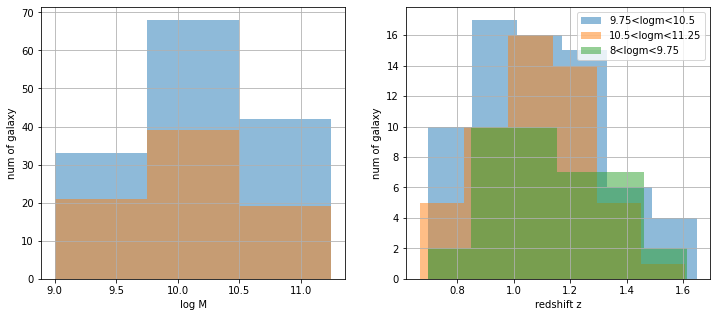

In [16]:
ax = plt.figure(figsize=(12,5))
ax.add_subplot(121)
plt.hist(np.log10(obj_lis['mass']),bins = [9,9.75,10.5,11.25],alpha=0.5)
plt.hist(np.log10(obj_lis_sel['mass']),bins = [9,9.75,10.5,11.25],alpha=0.5)
plt.xlabel('log M');plt.ylabel('num of galaxy')
plt.grid()

ax.add_subplot(122)
plt.hist(obj_lis[binning_m==2]['z_MAP'],bins=6,alpha=0.5,label=bin_label_m[1])
plt.hist(obj_lis[binning_m==3]['z_MAP'],bins=6,alpha=0.5,label=bin_label_m[2])
plt.hist(obj_lis[binning_m==1]['z_MAP'],bins=6,alpha=0.5,label=bin_label_m[0])

plt.xlabel('redshift z');plt.ylabel('num of galaxy')
plt.legend();plt.grid()
plt.show()


# radial profiles, in [kpc] radius

method 1 ha hb balmer data all from surface brightness measurement then taking the median

(2.7610472659656327, 1.4991482268451473)

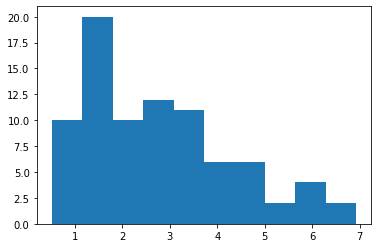

In [17]:
re_kpc = obj_lis_sel['re']/0.1*obj_lis_sel['pixel_length']
plt.hist(re_kpc,bins=10)
np.mean(re_kpc),np.std(re_kpc)

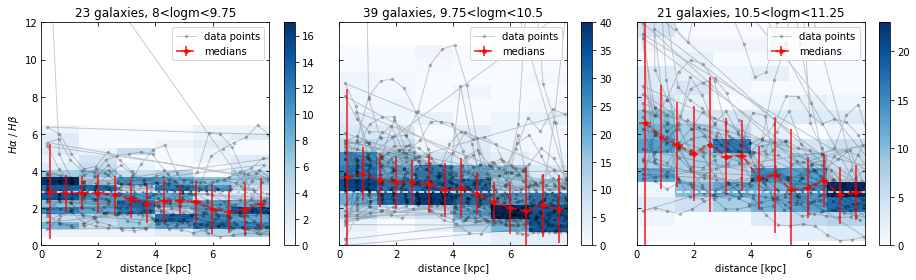

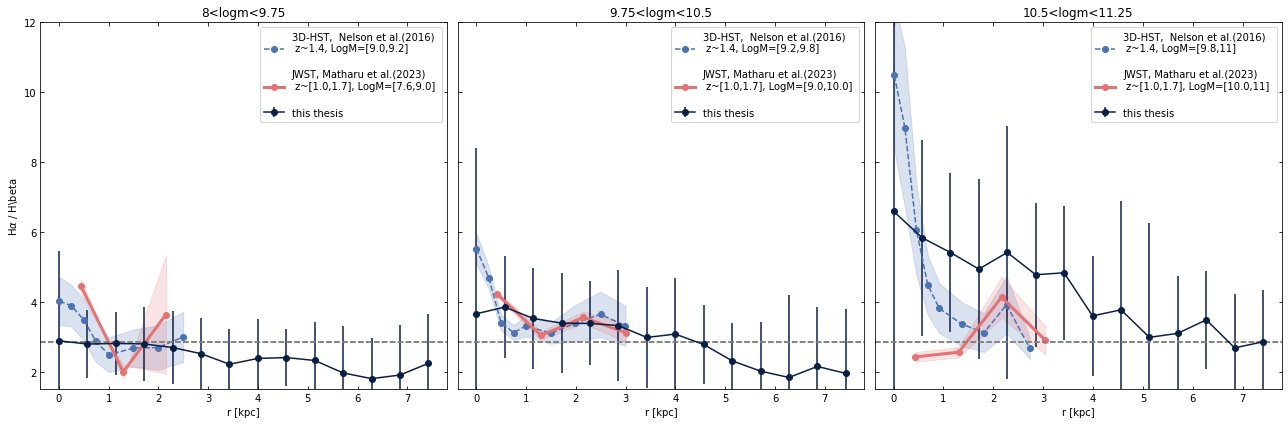

In [62]:
obj_lis_sel = obj_lis[select]
#obj_lis_sel = obj_lis_sel[:10]
#use back end to display the plot
%matplotlib inline

fig = plt.figure(figsize=(13, 4))  # Create a figure with size 13x4 inches

def bin_center(r_lis):
    diff = np.diff(r_lis)  # Calculate differences between consecutive elements
    diff = diff[diff > 0]  # Keep only positive differences
    return r_lis + np.mean(diff) / 2  # Return r_lis plus half the mean of the differences

binned_radius = []
median_balmer = []
median_balmer_err = []

for i in range(len(bins_m) - 1):
    ax = fig.add_subplot(1, 3, i + 1)  # Add a subplot in a 1x3 grid
    ax.tick_params(direction='in',which='both', top=True, right=True)
    if i !=0: ax.set_yticklabels([])

    r_lis = np.array([])  # Initialize r_lis as an empty array
    balmer_lis = np.array([])  # Initialize balmer_lis as an empty array

    for obj in obj_lis_sel[obj_lis_sel['bin_m'] == i + 1]:
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"  # Construct the file path
        with fits.open(path) as hdu:
            r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(find_data('RAD_PROFILE_ELLIP__CONV', hdu)[1].data).transpose()
            # Read and transpose data from the FITS file
            r_lis = np.append(r_lis, r)  # Append r to r_lis
            balmer_lis = np.append(balmer_lis, balmer_r)  # Append balmer_r to balmer_lis

    r_bins_center = bin_center(r_lis)  # Calculate the center of r_lis

    mask = np.logical_and(r_lis < 8, balmer_lis < 12000)  # Create a mask to filter r_lis < 3 

    mask_for_plot = np.logical_and(r_lis < 8, balmer_lis < 12)  # Create a mask for plotting
    plt.hist2d(r_lis[mask_for_plot], balmer_lis[mask_for_plot], bins=(6, 15), cmap='Blues')  # Plot a 2D histogram
    plt.colorbar()  # Add a color bar
    plt.plot(r_bins_center[mask],balmer_lis[mask], linewidth=1, marker='.',markersize=5, color='black', alpha=0.2,label='data points')  # Plot a scatter plot
    plt.title(f'{len(obj_lis_sel[binning_m_sel == i + 1])} galaxies, {bin_label_m[i]}')  # Set the subplot title
    plt.xlim(0,)  # Set the x-axis limit
    plt.ylim(0,12) #yaxis
    plt.xlabel('distance [kpc]')  # Set the x-axis label
    plt.axhline(2.86, 0, 7, linestyle='--', color='white')  # Draw a horizontal line

    if i == 0:
        plt.ylabel(r'$H\alpha$ / $H\beta$')
    # Radius binning and taking medians
    bin_edges = np.linspace(np.min(r_lis[mask]), np.max(r_lis[mask]), num=15)  # Calculate bin edges
    bin_indices = np.digitize(r_lis[mask], bin_edges)  # Assign r_lis values to bins
    median_values = [np.median(balmer_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))]  # Calculate median values for each bin
    std_values = [np.std(balmer_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))]  # Calculate standard deviation for each bin
    std_r_values = [np.std(r_lis[mask][bin_indices==j])for j in range(1,len(bin_edges))]
    # Plot medians
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
    plt.errorbar(bin_centers, median_values, yerr=std_values, xerr=std_r_values, fmt='--',color="r",alpha=0.7, linewidth=2,marker='o',markersize=4,label='medians',elinewidth=2)  # Plot medians with error bars
    
    #save_results
    binned_radius.append(bin_edges[:-1])
    median_balmer.append(median_values)
    median_balmer_err.append(std_values)
    plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('radial_balmer_decrem/test_radial_profile_median')
plt.show()  # Display the figure
#------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
hst3d_label = ['LogM=[9.0,9.2]','LogM=[9.2,9.8]','LogM=[9.8,11]']
jwst_label = ['LogM=[7.6,9.0]','LogM=[9.0,10.0]','LogM=[10.0,11]']
for i, ax in enumerate(axes):
    ax.tick_params(direction='in',which='both', top=True, right=True)

    r = binned_radius[i]
    median = median_balmer[i]
    std = median_balmer_err[i]
    
    # Use loop index i to select color, avoiding out of range
    color = ['r', 'g', 'b'][i % 3]  # Use modulo operation to ensure index is within range
    mass  = ['low','middle','high'][i%3]
    r_theo1, balmer_theo1, balmer_err_theo1 = hst3d_result(mass)
    r_theo2, balmer_theo2, balmer_err_theo2 = jwst_result(mass)

    ax.errorbar(r, median, yerr=std, marker='o', fmt='-', color="#0A1F44", label='this thesis')  # Add label for distinction
    
    ax.plot(r_theo1,balmer_theo1,marker='o',linestyle='--',color="#4C72B0",label=f'3D-HST,  Nelson et al.(2016) \n z~1.4, {hst3d_label[i]} \n')
    ax.axhline(2.86, linestyle='--', color='grey')  # Draw a horizontal line
    ax.fill_between(r_theo1,balmer_theo1-balmer_err_theo1,balmer_theo1+balmer_err_theo1,color="#4C72B0",alpha=0.2)
    
    ax.plot(r_theo2,balmer_theo2,marker='o',linestyle='-',color="#E57373",label=f'JWST, Matharu et al.(2023) \n z~[1.0,1.7], {jwst_label[i]} \n',linewidth=3)
    ax.axhline(2.86, linestyle='--', color='grey')  # Draw a horizontal line
    ax.fill_between(r_theo2,balmer_theo2-balmer_err_theo2,balmer_theo2+balmer_err_theo2,color="#E57373",alpha=0.2)
    
    
    # Add legend
    ax.legend()
    # Add title and axis labels
    ax.set_title(bin_label_m[i])
    ax.set_xlabel('r [kpc]')
    if i ==0:
        ax.set_ylabel(r'H$\alpha$ / H\beta')
    if i !=0:
        ax.set_yticklabels([])
    ax.set_ylim(1.5,12)
# Display the plot
plt.tight_layout()
plt.savefig('radial_balmer_decrem/test2_comparison')
plt.show()

things can be written in results or discussion:

disagreement in the center region

disagreement around 1 1.5 radius

other places: maybe ok?



disagreement in the center
    3dhst theoretical data: psf deconvolved? -> higher flux in both ha hb center
    too strong NII correction for Ha?; gradient correction needed?

higher dust attenutation in around 1-1.5 region
    maybe due to the hb convolved with the matching kernel? so the size of the Hb spreads out.

other problems:
    very high error from the scatter of the data points v.s. small error from the integrated results from others work
    z range of CLEAR is larger towards the low z end. SO redshift binning maybe also needed? (but small sample size)






## add redshift binning

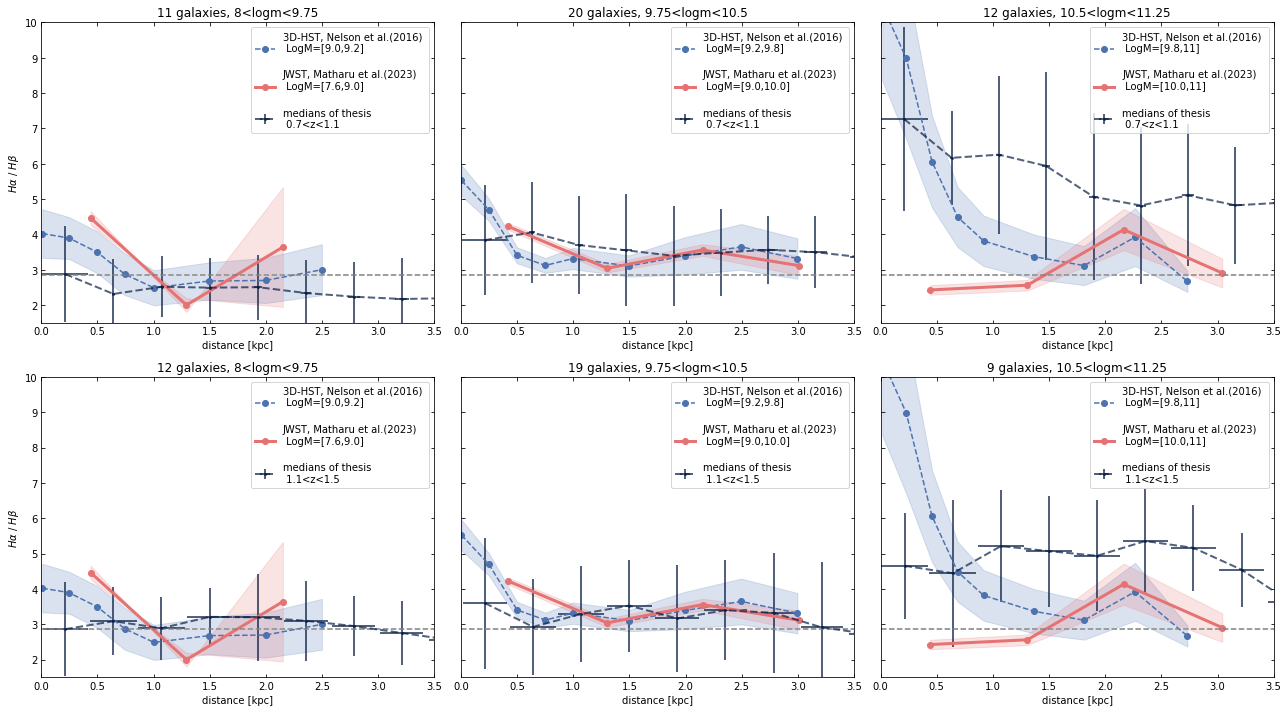

In [57]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Create a figure with 2x3 subplots

def bin_center(r_lis):
    diff = np.diff(r_lis)  # Calculate differences between consecutive elements
    diff = diff[diff > 0]  # Keep only positive differences
    return r_lis + np.mean(diff) / 2  # Return r_lis plus half the mean of the differences

binned_radius = []
median_balmer = []
median_balmer_err = []

for i in range(len(bins_m) - 1):
    for j in range(len(bins_z) - 1):
        ax = axes[j, i]  # Select the subplot in the 2x3 grid
        ax.tick_params(direction='in', which='both', top=True, right=True)
        if i != 0:
            ax.set_yticklabels([])

        r_lis = np.array([])  # Initialize r_lis as an empty array
        balmer_lis = np.array([])  # Initialize balmer_lis as an empty array

        for obj in obj_lis_sel[np.logical_and(obj_lis_sel['bin_m'] == i + 1, obj_lis_sel['bin_z'] == j + 1)]:
            path = f"data_extracted/{file_name(obj, prefix='extracted')}"  # Construct the file path
            with fits.open(path) as hdu:
                r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(find_data('RAD_PROFILE_ELLIP__CONV', hdu)[1].data).transpose()
                # Read and transpose data from the FITS file

                r_lis = np.append(r_lis, r)  # Append r to r_lis
                balmer_lis = np.append(balmer_lis, balmer_r)  # Append balmer_r to balmer_lis

        r_bins_center = bin_center(r_lis)  # Calculate the center of r_lis

        mask = np.logical_and(r_lis < 6, balmer_lis < 12)  # Create a mask to filter r_lis < 3 and balmer_lis < 12

        ax.set_title(f'{len(obj_lis_sel[np.logical_and(binning_m_sel == i + 1, binning_z_sel == j + 1)])} galaxies, {bin_label_m[i]}')  # Set the subplot title
        ax.set_xlim(0, 3.5)  # Set the x-axis limit
        ax.set_ylim(1.5, 10)
        ax.set_xlabel('distance [kpc]')  # Set the x-axis label
        ax.axhline(2.86, 0, 7, linestyle='--', color='white')  # Draw a horizontal line
        if i == 0:
            ax.set_ylabel(r'$H\alpha$ / $H\beta$')

        # Radius binning and taking medians
        bin_edges = np.linspace(np.min(r_lis[mask]), np.max(r_lis[mask]), num=15)  # Calculate bin edges
        bin_indices = np.digitize(r_lis[mask], bin_edges)  # Assign r_lis values to bins
        median_values = [np.median(balmer_lis[mask][bin_indices == k]) for k in range(1, len(bin_edges))]  # Calculate median values for each bin
        std_values = [np.std(balmer_lis[mask][bin_indices == k]) for k in range(1, len(bin_edges))]  # Calculate standard deviation for each bin
        std_r_values = [np.std(r_lis[mask][bin_indices == k]) for k in range(1, len(bin_edges))]
        # Plot medians
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
        ax.errorbar(bin_centers, median_values, yerr=std_values, xerr=std_r_values, fmt='--', color="#0A1F44", alpha=0.7, linewidth=2, marker='.', markersize=4, label=f'medians of thesis \n {bin_label_z[j]}', elinewidth=2)  # Plot medians with error bars

        # Save results
        binned_radius.append(bin_edges[:-1])
        median_balmer.append(median_values)
        median_balmer_err.append(std_values)

        # Plot theoretical results (no redshift distinction)
        mass = ['low', 'middle', 'high'][i % 3]
        r_theo1, balmer_theo1, balmer_err_theo1 = hst3d_result(mass)
        r_theo2, balmer_theo2, balmer_err_theo2 = jwst_result(mass)

        ax.plot(r_theo1, balmer_theo1, marker='o', linestyle='--', color="#4C72B0", label=f'3D-HST, Nelson et al.(2016) \n {hst3d_label[i]} \n')
        ax.fill_between(r_theo1, balmer_theo1 - balmer_err_theo1, balmer_theo1 + balmer_err_theo1, color="#4C72B0", alpha=0.2)

        ax.plot(r_theo2, balmer_theo2, marker='o', linestyle='-', color="#E57373", label=f'JWST, Matharu et al.(2023) \n {jwst_label[i]} \n', linewidth=3)
        ax.fill_between(r_theo2, balmer_theo2 - balmer_err_theo2, balmer_theo2 + balmer_err_theo2, color="#E57373", alpha=0.2)

        ax.axhline(2.86, linestyle='--', color='grey')  # Draw a horizontal line
        ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig('radial_balmer_decrem/test_radial_profile_median')
plt.show()  # Display the figure


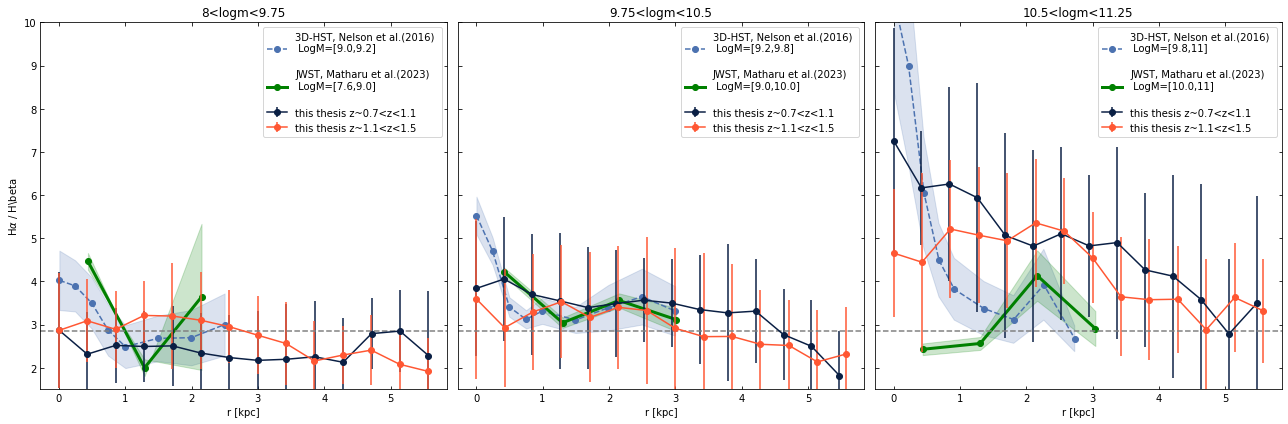

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
hst3d_label = ['LogM=[9.0,9.2]', 'LogM=[9.2,9.8]', 'LogM=[9.8,11]']
jwst_label = ['LogM=[7.6,9.0]', 'LogM=[9.0,10.0]', 'LogM=[10.0,11]']

for i, ax in enumerate(axes):
    ax.tick_params(direction='in', which='both', top=True, right=True)

    # Plot theoretical results (no redshift distinction)
    mass = ['low', 'middle', 'high'][i % 3]
    r_theo1, balmer_theo1, balmer_err_theo1 = hst3d_result(mass)
    r_theo2, balmer_theo2, balmer_err_theo2 = jwst_result(mass)
    
    ax.plot(r_theo1, balmer_theo1, marker='o', linestyle='--', color="#4C72B0", label=f'3D-HST, Nelson et al.(2016) \n {hst3d_label[i]} \n')
    ax.fill_between(r_theo1, balmer_theo1 - balmer_err_theo1, balmer_theo1 + balmer_err_theo1, color="#4C72B0", alpha=0.2)
    
    ax.plot(r_theo2, balmer_theo2, marker='o', linestyle='-', color="g", label=f'JWST, Matharu et al.(2023) \n {jwst_label[i]} \n', linewidth=3)
    ax.fill_between(r_theo2, balmer_theo2 - balmer_err_theo2, balmer_theo2 + balmer_err_theo2, color="g", alpha=0.2)
    
    # Plot actual results for different redshifts
    for j in range(len(bins_z) - 1):
        r = binned_radius[i * (len(bins_z) - 1) + j]
        median = median_balmer[i * (len(bins_z) - 1) + j]
        std = median_balmer_err[i * (len(bins_z) - 1) + j]
        
        ax.errorbar(r, median, yerr=std, marker='o', fmt='-', color=["#0A1F44", "#FF5733"][j], label=f'this thesis z~{bin_label_z[j]}')  # Add label for distinction
    
    ax.axhline(2.86, linestyle='--', color='grey')  # Draw a horizontal line
    
    # Add legend
    ax.legend()
    # Add title and axis labels
    ax.set_title(bin_label_m[i])
    ax.set_xlabel('r [kpc]')
    if i == 0:
        ax.set_ylabel(r'H$\alpha$ / H\beta')
    if i != 0:
        ax.set_yticklabels([])
    ax.set_ylim(1.5, 10)

# Display the plot
plt.tight_layout()
plt.savefig('radial_balmer_decrem/test2_comparison')
plt.show()

# attenuation, in kpc

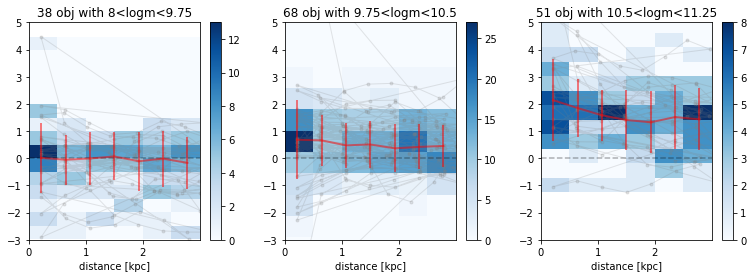

In [43]:
fig = plt.figure(figsize=(13, 4))  # Create a figure with size 13x4 inches

for i in range(len(bins_m) - 1):
    ax = fig.add_subplot(1, 3, i + 1)  # Add a subplot in a 1x3 grid
    r_lis = np.array([])  # Initialize r_lis as an empty array
    A_lis = np.array([])  # Initialize balmer_lis as an empty array

    for obj in obj_lis_sel[obj_lis_sel['bin_m'] == i + 1]:
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"  # Construct the file path
        with fits.open(path) as hdu:
            r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(find_data('RAD_PROFILE_ELLIP__CONV', hdu)[1].data).transpose()
            # Read and transpose data from the FITS file

            r_lis = np.append(r_lis, r)  # Append r to r_lis
            A_lis = np.append(A_lis, A_a)  # Append balmer_r to balmer_lis

    r_bins_center = bin_center(r_lis)  # Calculate the center of r_lis

    mask = np.logical_and(r_lis < 3, np.isfinite(A_lis))  # Create a mask to filter r_lis < 3 and balmer_lis < 12
    plt.hist2d(r_lis[mask], A_lis[mask], bins=(6, 15), cmap='Blues')  # Plot a 2D histogram
    plt.plot(r_bins_center[mask], A_lis[mask], linewidth=1, marker='.', color='grey', alpha=0.2)  # Plot a scatter plot
    plt.title(f'{len(obj_lis[binning_m == i + 1])} obj with {bin_label_m[i]}')  # Set the subplot title
    plt.xlim(0,)  # Set the x-axis limit
    plt.ylim(-3,5)
    plt.xlabel('distance [kpc]')  # Set the x-axis label
    plt.axhline(0, 0, 7, linestyle='--', color='black',alpha=0.3)  # Draw a horizontal line
    plt.colorbar()  # Add a color bar

    # Radius binning and taking medians
    bin_edges = np.linspace(np.min(r_lis[mask]), np.max(r_lis[mask]), num=8)  # Calculate bin edges
    bin_indices = np.digitize(r_lis[mask], bin_edges)  # Assign r_lis values to bins
    median_values = [np.median(A_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))]  # Calculate median values for each bin
    std_values = [np.std(A_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))]  # Calculate standard deviation for each bin

    # Plot medians
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
    plt.errorbar(bin_centers, median_values, yerr=std_values, fmt='r-', linewidth=2,alpha=0.5)  # Plot medians with error bars

plt.show()  # Display the figure

# radial profiles, in r_eff

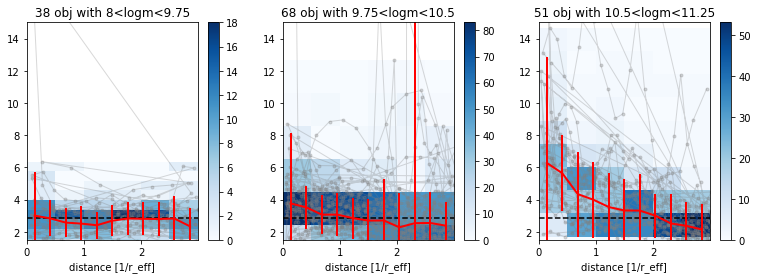

In [76]:
fig = plt.figure(figsize=(13, 4))

for i in range(len(bins_m) - 1):
    ax = fig.add_subplot(1, 3, i + 1)
    r_lis = np.array([])
    r_bins_center = np.array([])
    A_lis = np.array([])
    r_pix_lis = np.array([])
    balmer_pix_lis = np.array([])

    for obj in obj_lis_sel[obj_lis_sel['bin_m'] == i + 1]:
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"
        with fits.open(path) as hdu:
            r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(find_data('RAD_PROFILE_ELLIP__CONV', hdu)[1].data).transpose()
            # Convert actual radius to effective radius
            r = r / (obj['re']/0.1*obj['pixel_length'])
            r_bins_center = np.append(r_bins_center,bin_center(r))
            r_lis = np.append(r_lis, r)
            A_lis = np.append(A_lis, balmer_r)

            distances_obj, balmer_pix, balmer_pix_err = np.vstack(find_data('PIX_RAD_PROFILE', hdu)[1].data).transpose()
            r_pix_lis = np.append(r_pix_lis, distances_obj)
            balmer_pix_lis = np.append(balmer_pix_lis, balmer_pix)

    
    # Mask
    mask = np.logical_and(r_lis < 3, np.isfinite(A_lis))
    mask_for_plot = np.logical_and(r_lis < 3, A_lis < 15)
    plt.hist2d(r_lis[mask_for_plot], A_lis[mask_for_plot], bins=(6, 10), cmap='Blues')
    plt.plot(r_bins_center[mask], A_lis[mask], linewidth=1, marker='o', markersize=3,color='grey', alpha=0.3)
    #plt.xlim(-0.1);plt.ylim(0,15) 
    plt.title(f'{len(obj_lis[binning_m == i + 1])} obj with {bin_label_m[i]}')
    plt.xlabel('distance [1/r_eff]')
    plt.axhline(2.86, 0, 7, linestyle='--', color='black',alpha=1)
    plt.colorbar()

    # Bin the radius and calculate the median of each binned radius
    bin_edges = np.linspace(np.min(r_lis[mask]), np.max(r_lis[mask]), num=12)
    bin_indices = np.digitize(r_lis[mask], bin_edges)
    median_values = [np.median(A_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))]
    std_values    = [np.std(A_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))]

    # Plot the median line
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.errorbar(bin_centers, median_values,yerr= std_values,fmt='r-', linewidth=2)
    plt.ylim(1.5,15)
plt.show()

# attenuation in r_eff

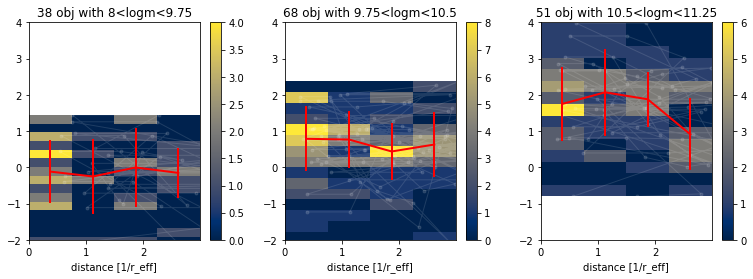

In [7]:
ax =plt.figure(figsize=(13,4))

for i in range(len(bins_m)-1):
    ax.add_subplot(int(f'13{i+1}'))
    r_lis = np.array(());     r_bins_center = np.array([])
    A_lis = np.array(())
    r_pix_lis = np.array(()); balmer_pix_lis = np.array(())


    for obj in obj_lis_sel[obj_lis_sel['bin_m']==i+1]:
        path = f"data_extracted/{file_name(obj,prefix='extracted')}"
        with fits.open(path) as hdu:
            r,ha_r,ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(find_data('RAD_PROFILE_CONV',hdu)[1].data).transpose()
            #now convert actual radius to effective radius
            r = r / obj['re']
            r_bins_center = np.append(r_bins_center,bin_center(r))
            r_lis = np.append(r_lis,r)
            A_lis = np.append(A_lis,A_a)

            distances_obj, balmer_pix, balmer_pix_err = np.vstack(find_data('PIX_RAD_PROFILE',hdu)[1].data).transpose()
            r_pix_lis = np.append(r_pix_lis,distances_obj)
            balmer_pix_lis = np.append(balmer_pix_lis,balmer_pix)

    mask = np.logical_and(r_lis<3,np.isfinite(A_lis))
    plt.hist2d(r_lis[mask],A_lis[mask],bins=(4,15),cmap = 'cividis')#, bins=(10,20))
    plt.plot(r_bins_center[mask],A_lis[mask],linewidth=1,marker='.',color='white',alpha=0.12)
    plt.ylim(-2,4)
    plt.title(f'{len(obj_lis[binning_m==i+1])} obj with {bin_label_m[i]}')
    plt.xlabel('distance [1/r_eff]')
    plt.colorbar()


    # Bin the radius and calculate the median of each binned radius
    bin_edges = np.linspace(np.min(r_lis[mask]), np.max(r_lis[mask]), num=5)
    bin_indices = np.digitize(r_lis[mask], bin_edges)
    median_values = [np.median(A_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))]
    std_values    = [np.std(A_lis[mask][bin_indices == j]) for j in range(1, len(bin_edges))]

    # Plot the median line
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.errorbar(bin_centers, median_values,yerr= std_values,fmt='r-', linewidth=2)

plt.show()

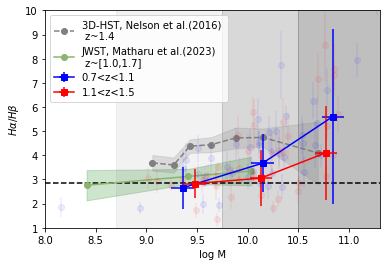

In [2]:
# Calculate Balmer Decrement
ha_flux = obj_lis_sel['Ha_FLUX']
hb_flux = obj_lis_sel['Hb_FLUX']
ha_flux_err = obj_lis_sel['Ha_FLUX_ERR']
hb_flux_err = obj_lis_sel['Hb_FLUX_ERR']

# Avoid division by zero
hb_flux[hb_flux == 0] = np.nan

# Calculate Balmer Decrement
balmer_decrement = ha_flux / hb_flux

# Calculate the error of Balmer Decrement
balmer_decrement_err = balmer_decrement * np.sqrt((ha_flux_err / ha_flux)**2 + (hb_flux_err / hb_flux)**2)

# Calculate weighted averages and standard deviations for each mass bin within each redshift bin
mass_bin_centers = []
balmer_decrement_means = []
balmer_decrement_stds = []

for z_bin, z_label in zip([obj_lis_sel['bin_z'] == i for i in range(1, len(bins_z))], bin_label_z):
    mass_bin_centers_z = []
    balmer_decrement_means_z = []
    balmer_decrement_stds_z = []

    for j in range(len(bins_m) - 1):
        mass_sub_bin = np.logical_and(z_bin, obj_lis_sel['bin_m'] == j + 1)
        
        if np.sum(mass_sub_bin) > 0:
            weights = 1 / balmer_decrement_err[mass_sub_bin]**2
            weighted_avg = np.sum(balmer_decrement[mass_sub_bin] * weights) / np.sum(weights)
            weighted_std = (np.sqrt(1 / np.sum(weights))**2 + np.std(balmer_decrement[mass_sub_bin])**2)**0.5
            mass_std = np.std(np.log10(obj_lis_sel['mass'][mass_sub_bin]))
            mass_bin_centers_z.append(np.mean(np.log10(obj_lis_sel['mass'][mass_sub_bin])))
            balmer_decrement_means_z.append(weighted_avg)
            balmer_decrement_stds_z.append(weighted_std)

    mass_bin_centers.append(mass_bin_centers_z)
    balmer_decrement_means.append(balmer_decrement_means_z)
    balmer_decrement_stds.append(balmer_decrement_stds_z)

# Plot the results
colors = ['blue', 'red']
plotspan = 8.7,9.75,10.5,11.5
plt.axhline(2.86, linestyle='--', color='black')

#literature value
m_theo, b_theo, b_theo_err = integrated_hst3d()
m_theo1, b_theo1, b_theo_err1 = integrated_jwst()
plt.plot(m_theo,b_theo,marker='o',linestyle='--',color='grey',label='3D-HST, Nelson et al.(2016) \n z~1.4')
plt.fill_between(m_theo,b_theo-b_theo_err,b_theo+b_theo_err,color='grey',alpha=0.2)
plt.plot(m_theo1,b_theo1,marker='o',linestyle='-',color="#8CB46F",label='JWST, Matharu et al.(2023) \n z~[1.0,1.7]')
plt.fill_between(m_theo1,b_theo1-b_theo_err1,b_theo1+b_theo_err1,color='green',alpha=0.2)


for j in range(len(bins_m) - 1):
    plt.axvspan(plotspan[j],plotspan[j+1], color='grey', alpha=[0.1,0.3,0.5][j])
for i, z_label in enumerate(bin_label_z):
    plt.errorbar(mass_bin_centers[i], balmer_decrement_means[i], yerr=balmer_decrement_stds[i], xerr=mass_std,
                marker='s', fmt='-', color=colors[i], alpha=1, label=z_label)
    plt.errorbar(np.log10(obj_lis_sel['mass'][obj_lis_sel['bin_z'] == i + 1]), balmer_decrement[obj_lis_sel['bin_z'] == i + 1], yerr=balmer_decrement_err[obj_lis_sel['bin_z'] == i + 1], 
                 fmt='o', color=colors[i], alpha=0.07)
plt.xlim(8.0,11.3)
plt.ylim(1,10)
plt.xlabel('log M')
plt.ylabel(r'$H\alpha / H\beta$')
plt.legend(loc='upper left')
plt.show()



In [ ]:
https://academic.oup.com/mnras/article/513/3/4431/6570912

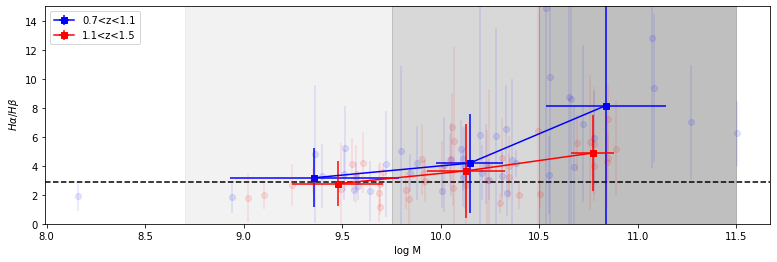

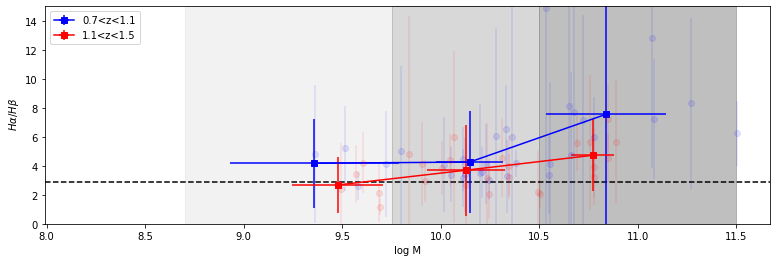

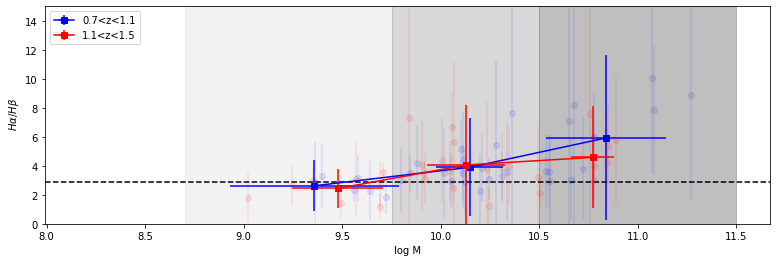

In [31]:
def radius_average(r_min, r_max):
    avg_balmer_zm = []; avg_balmer_zm_err = []
    for z_bin, z_label in zip([obj_lis_sel['bin_z'] == i for i in range(1, len(bins_z))], bin_label_z):
        avg_balmer_z = []
        avg_balmer_err_z = []
        
        # 对每个对象进行循环
        for obj in obj_lis_sel[z_bin]:
            path = f"data_extracted/{file_name(obj, prefix='extracted')}"
            with fits.open(path) as hdu:
                r, ha_r, ha_r_err, hb_r, hb_r_err, balmer, balmer_err, E_ba, A_a = np.vstack(find_data('RAD_PROFILE_CONV', hdu)[1].data).transpose()
                r = r / obj['re']
                # 对给定半径范围内的 surface brightness 进行平均计算
                mask = (r >= r_min) & (r <= r_max)
                avg_balmer = np.mean(balmer[mask])
                avg_balmer_err = (np.std(balmer[mask])**2 + np.mean(balmer_err[mask])**2)**0.5

                avg_balmer_z.append(avg_balmer)
                avg_balmer_err_z.append(avg_balmer_err)
        
        avg_balmer_zm.append(avg_balmer_z)
        avg_balmer_zm_err.append(avg_balmer_err_z)
    return avg_balmer_zm, avg_balmer_zm_err



def plot_radius_average(r_min, r_max):
    fig = plt.figure(figsize=(13, 4))
    for j in range(len(bins_m) - 1):
        plt.axvspan(plotspan[j], plotspan[j+1], color='grey', alpha=[0.1,0.3,0.5][j])
    plt.axhline(2.86, linestyle='--', color='black')
    # Calculate the average Balmer decrement for the radius range (0, 1)
    avg_balmer_zm, avg_balmer_zm_err = radius_average(r_min, r_max)
    colors = ['blue', 'red']
    for i, z_label in enumerate(bin_label_z):
        avg_balmer_z = avg_balmer_zm[i]
        avg_balmer_err_z = avg_balmer_zm_err[i]
        masses = np.log10(obj_lis_sel['mass'][obj_lis_sel['bin_z'] == i + 1])
        
        # Calculate the average and error for each mass bin
        mass_bins = np.digitize(masses, bins=bins_m)
        avg_mass_balmer = []
        avg_mass_balmer_err = []
        avg_mass_positions = []
        avg_mass_positions_err = []

        for j in range(1, len(bins_m)):
            mask = mass_bins == j
            if np.sum(mask) > 0:
                avg_mass_balmer.append(np.nanmean(np.array(avg_balmer_z)[mask]))
                avg_mass_balmer_err.append(np.nanmean(np.array(avg_balmer_err_z)[mask]))
                avg_mass_positions.append(np.nanmean(masses[mask]))
                avg_mass_positions_err.append(np.nanstd(masses[mask]))
            else:
                avg_mass_balmer.append(np.nan)
                avg_mass_balmer_err.append(np.nan)
                avg_mass_positions.append(np.nan)
                avg_mass_positions_err.append(np.nan)

        # Plot the average Balmer decrement for each mass bin
        plt.errorbar(avg_mass_positions, avg_mass_balmer, yerr=avg_mass_balmer_err, xerr=avg_mass_positions_err,
                        marker='s', fmt='-', color=colors[i], alpha=1, label=z_label)
        plt.errorbar(masses, avg_balmer_z, yerr=avg_balmer_err_z, fmt='o', color=colors[i], alpha=0.1)

    plt.ylim(0,15)
    plt.xlabel('log M')
    plt.ylabel(r' $H\alpha / H\beta$')
    plt.legend()
    plt.show()

for radius in [(0, 1), (1, 2), (2, 3)]:
    plot_radius_average(*radius)

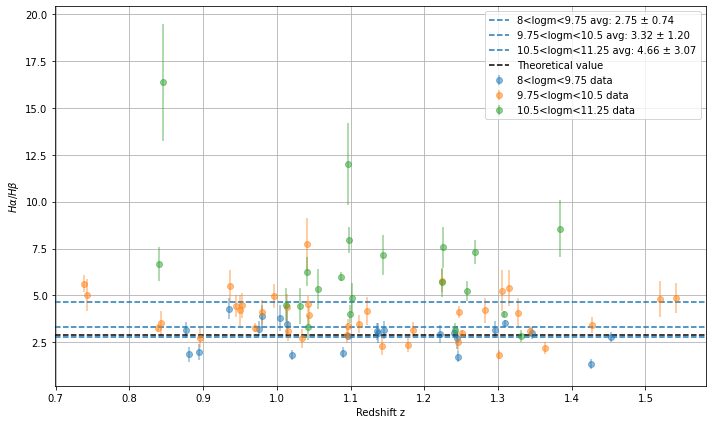

In [16]:
# Plot Balmer Decrement against redshift with mass binning
fig, ax = plt.subplots(figsize=(10, 6))

# Define mass bins and labels
mass_bins = [obj_lis_sel['bin_m'] == i for i in range(1, len(bins_m))]
mass_labels = bin_label_m

# Plot each mass bin
for mass_bin, mass_label in zip(mass_bins, mass_labels):
    z_values = obj_lis_sel['z_MAP'][mass_bin]
    balmer_values = balmer_decrement[mass_bin]
    balmer_errors = balmer_decrement_err[mass_bin]

    # Calculate weighted averages and standard deviations
    weights = 1 / balmer_errors**2
    weighted_avg = np.sum(balmer_values * weights) / np.sum(weights)
    weighted_std = (np.sqrt(1 / np.sum(weights))**2 + np.std(balmer_values)**2)**0.5

    # Plot data points
    ax.errorbar(z_values, balmer_values, yerr=balmer_errors, fmt='o', alpha=0.5, label=f'{mass_label} data')

    # Plot average line
    ax.axhline(weighted_avg, linestyle='--', label=f'{mass_label} avg: {weighted_avg:.2f} ± {weighted_std:.2f}')

# Add horizontal line for theoretical value
ax.axhline(2.86, linestyle='--', color='black', label='Theoretical value')

# Add labels and legend
ax.set_xlabel('Redshift z')
ax.set_ylabel(r'$H\alpha / H\beta$')
ax.legend()
ax.grid(True)

# Show plot
plt.tight_layout()
plt.show()